In [9]:
import os
import re

import csv

import requests

from bs4 import BeautifulSoup

In [10]:
def get_text(soup):
    text = ""
    for paragraph in soup.find_all('p'):
        if not paragraph.has_attr('class') and not paragraph.findChildren('b'):
            text += paragraph.get_text() + "\n\n"
            
    return text

In [11]:
def get_npr_urls(soup):
    
    pattern = r'20[\d]{2}/[\d]{1,2}/[\d]{1,2}/[\d]+/'
    
    urls = []
    for link in soup.find_all('a', href=True):
        url = link['href']
        if (url.startswith('https://www.npr.org/')):
            if re.search(pattern, url):
                urls.append(url)
        
    return urls

In [12]:
def get_title(soup):
    title = ""
    #find href with class == title, then get b
    for link in soup.find_all('a'):
        if link.has_attr('class'):
            if link['class'][0] == "title":
                title = link.findChildren('b')[0].get_text()
    
    return title

In [13]:
def get_details(url):
    pattern = r'20[\d]{2}/[\d]{1,2}/[\d]{1,2}/[\d]+/'
    
    matchObject = re.search(pattern, url, flags=0)
    match_split = matchObject[0].split("/")
    date = match_split[0] + "-" + match_split[1] + "-" + match_split[2]
    article_id = match_split[3]
    
    return date, article_id

In [26]:
##############
## 

start_url = "https://www.npr.org/"
traversed_urls = set()

write = True
max_traverse = 50

to_traverse = set()
to_traverse.add(start_url)

folder_out = 'data/articles/'
if not os.path.exists(folder_out):
    os.makedirs(folder_out)

article_count = 0
traversed_to_future_list = []

with open(folder_out + "article_log.csv", 'w') as csvfile:
    
    if write:
        fieldnames = ["ID", "Date", "Title", "Link"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
    while len(to_traverse) > 0 and article_count < max_traverse:
        traversed_to_future_list.append({
            "Traversed": len(traversed_urls),
            "To Traverse": len(to_traverse)
        })
        
        if article_count % 50 == 0:
            print(article_count, ":", len(to_traverse))
        url = to_traverse.pop()
        traversed_urls.add(url)

        soup = BeautifulSoup(requests.get(url).text, 'html.parser')

        links = get_npr_urls(soup)

        urls = [x for x in get_npr_urls(soup) if x not in traversed_urls]
        to_traverse.update(urls)

        text = get_text(soup)

        if len(text) > 100:
            title = get_title(soup)
            date, article_id = get_details(url)

            if write:
                writer.writerow({"Link": url, "Title": title, "Date": date, "ID": article_id})
                with open (folder_out + article_id + ".txt", 'w') as article_hdl:
                    article_hdl.write(text)
            

        article_count += 1

0 : 1


In [7]:
import glob
len(glob.glob(folder_out + "*.txt"))

1938

In [22]:
with open (folder_out + "article_log.csv") as csv_hdl:
    count = 0
    reader = csv.reader(csv_hdl)
    for row in reader:
        count+=1
        
    print (count)

0


In [16]:
len(traversed_to_future_list)

2000

In [23]:
import pandas as pd

url_df = pd.DataFrame(traversed_to_future_list)


In [18]:
%matplotlib inline 

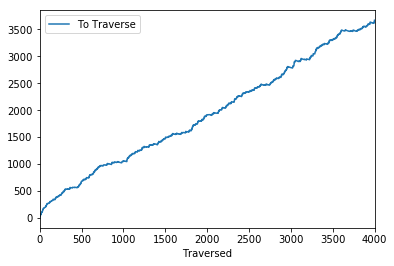

In [24]:
url_df.plot(x="Traversed")